# Simple Retrieval Augmented Generation (RAG) with OpenAI

Retrieves relevant documents based on the query and uses them to generate an answer

**When to use:** Basic question-answering tasks where context is needed

Author: [Manoj Jahgirdar](https://www.linkedin.com/in/manojjahgirdar)

## Retrieval-Augmented Generation (RAG) Pipeline

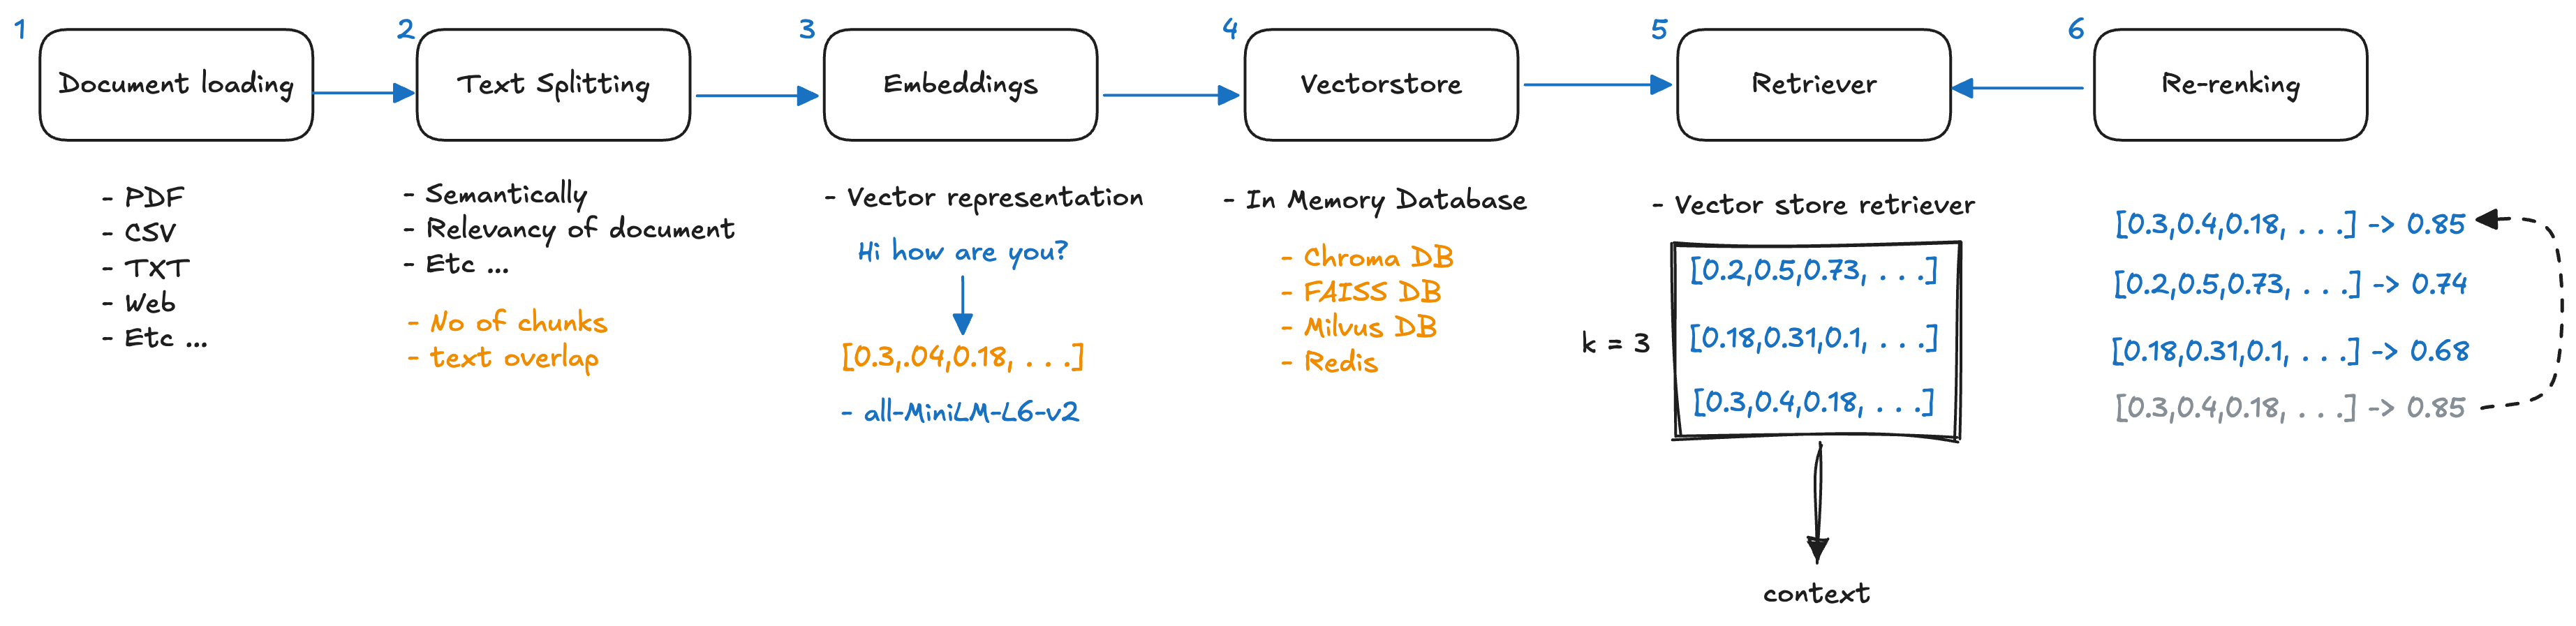

## Install dependencies

In [ ]:
%pip install --quiet --upgrade sentence-transformers faiss-cpu rank_llm pymupdf
%pip install --quiet --upgrade langchain-text-splitters langchain-community langgraph langchain-chroma langchain_openai langchain-huggingface

## Export environment variables

In [1]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

OPENAI_API_KEY:  ········


In [2]:
_set_env("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "rag-techniques"

LANGCHAIN_API_KEY:  ········


## Step 1: Document Loading

In [3]:
from langchain_community.document_loaders import PyMuPDFLoader

In [5]:
file_path = "documents/formula1-technical-regulations.pdf"
loader = PyMuPDFLoader(file_path)
docs = loader.load()
print(f"{len(docs)} Pages loaded")

179 Pages loaded


## Step 2: Text splitting

In [6]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

In [7]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
all_splits = text_splitter.split_documents(docs)
print(f"{len(docs)} Pages split into '{len(all_splits)}' chunks")

179 Pages split into '682' chunks


## Step 3: Embeddings

In [8]:
from langchain_huggingface import HuggingFaceEmbeddings

In [9]:
embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-mpnet-base-v2")

## Step 4: Define Vectorstore

In [10]:
from langchain_chroma import Chroma

vector_store = Chroma(
    collection_name="formula-one",
    embedding_function=embeddings,
    persist_directory="./chroma_langchain_db",  # Where to save data locally, remove if not necessary
)

In [11]:
_ = vector_store.add_documents(documents=all_splits)

## Step 5: Retriever

In [12]:
# Helper function for printing docs
def pretty_print_docs(docs):
    print(
        f"\n{'-' * 100}\n".join(
            [f"Document {i + 1}:\n\n" + d.page_content for i, d in enumerate(docs)]
        )
    )

In [13]:
retrieved_docs = vector_store.similarity_search("What are the Aerodynamic Components of the formula one car?", k=3)
docs_content = "\n\n".join(doc.page_content for doc in retrieved_docs)
# pretty_print_docs(retrieved_docs)

## Step 6: Re-ranking

In [14]:
from langchain.retrievers.contextual_compression import ContextualCompressionRetriever
from langchain_community.document_compressors.rankllm_rerank import RankLLMRerank

In [15]:
retriever = vector_store.from_documents(all_splits, embeddings).as_retriever(search_kwargs={"k": 4})

In [17]:
query = "What are the Aerodynamic Components of the formula one car?"
docs = retriever.invoke(query)
# pretty_print_docs(docs)

In [18]:
import torch
from langchain.retrievers.contextual_compression import ContextualCompressionRetriever
from langchain_community.document_compressors.rankllm_rerank import RankLLMRerank

torch.cuda.empty_cache()

compressor = RankLLMRerank(top_n=3, model="gpt", gpt_model="gpt-4o-mini")
compression_retriever = ContextualCompressionRetriever(
    base_compressor=compressor, base_retriever=retriever
)

del compressor

In [ ]:
compressed_docs = compression_retriever.invoke(query)
pretty_print_docs(compressed_docs)

## Define Large Language Model (LLM)

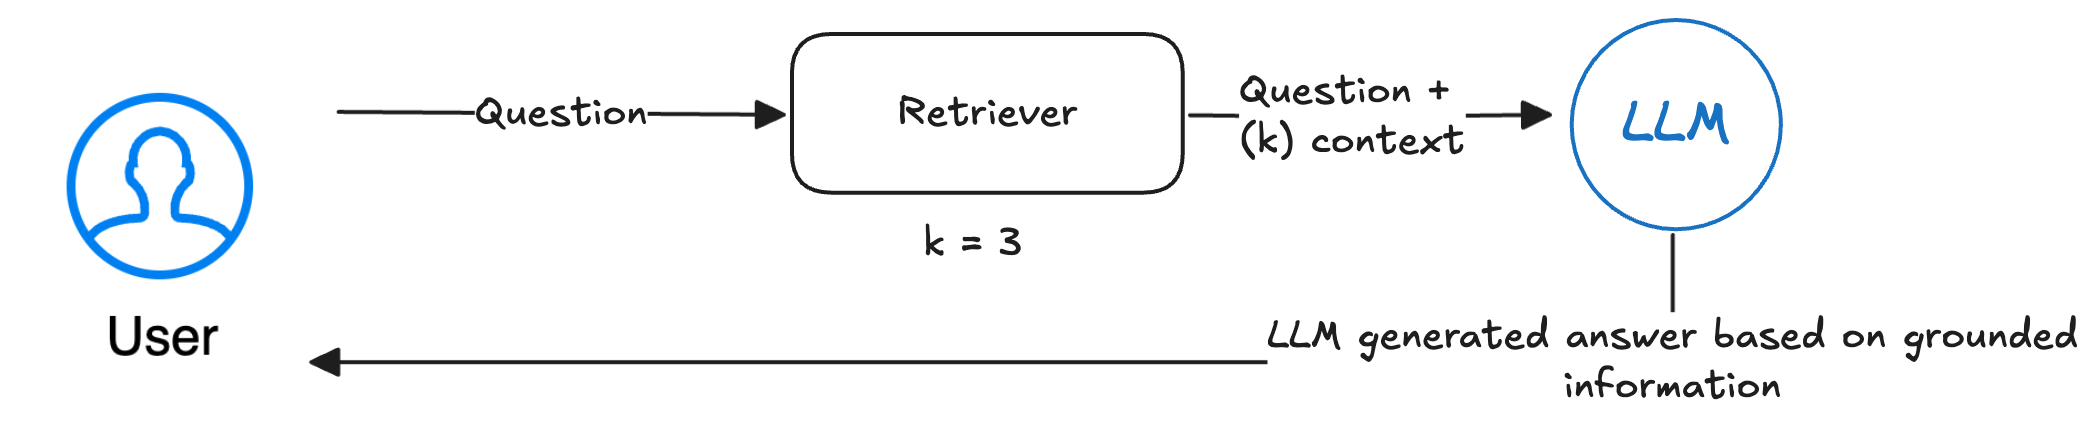

In [19]:
import getpass
import os
from langchain.chat_models import init_chat_model

llm = init_chat_model("gpt-4o-mini", model_provider="openai")

In [28]:
prompt = """You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Keep the answer concise.

Context: 
{context} 

Question: 
{question} 

Answer: (with references)"""

## Define Graph with LangGraph

In [29]:
from langchain_core.documents import Document
from typing_extensions import List, TypedDict


class State(TypedDict):
    question: str
    context: List[Document]
    answer: str

In [30]:
def retrieve(state: State):
    retrieved_docs = vector_store.similarity_search(state["question"])
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.format(question=state["question"], context=docs_content)
    response = llm.invoke(messages)
    return {"answer": response.content}

In [31]:
from langgraph.graph import START, StateGraph

graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

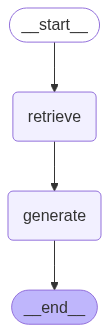

In [32]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [33]:
result = graph.invoke({"question": "What are the Aerodynamic Components of the formula one car?"})

# print(f'Context: {result["context"]}\n\n')
print(f'Answer: {result["answer"]}')

2025-07-10 21:17:59,272 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Answer: The aerodynamic components of a Formula One car, as defined in the 2025 Technical Regulations, include:

1. All parts of the car in contact with the external air stream.
2. Components considered as bodywork include:
   - All components described in Article 3.
   - Inlet or outlet ducts for cooling purposes, up to the component they cool.
   - Inlet ducts for the power unit (air boxes) up to the air filter.
   - Primary heat exchangers (defined in Article 7.4.1 (b)).

Certain components are explicitly not considered to be bodywork, including cameras, rear view mirrors, the ERS status light, and parts associated with the mechanical functioning of the power train (Article 3.1.1).


In [36]:
result = graph.invoke({"question": "What is the functionality of a Halo ring?"})

# print(f'Context: {result["context"]}\n\n')
print(f'Answer: {result["answer"]}')

2025-07-10 21:18:19,040 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Answer: The Halo ring, known as the secondary roll structure, is designed to protect the driver in the event of a rollover incident. It must be positioned symmetrically about the car center plane with specific mounting requirements to ensure its effectiveness. The Halo structure is not considered part of the survival cell but is essential for enhancing safety by providing additional protection to the driver's head and upper body in crashes. It must be constructed according to the FIA8869-2018 standards.


---